In [32]:
import numpy as np
import pandas as pd
np.random.seed(1337)  # for reproducibility
from tensorflow.keras.models import *
from tensorflow.keras.layers import Input, Dense, Multiply, Embedding, Flatten
from tensorflow.keras.backend import flatten, batch_flatten

In [5]:
path = './data/ChnSentiCorp_htl_all.csv'
pd_all = pd.read_csv(path)

# Preprocessing

### Generate balanced corpus

In [6]:
pd_positive = pd_all[pd_all.label==1]
pd_negative = pd_all[pd_all.label==0]

def get_balance_corpus(corpus_size, corpus_pos, corpus_neg):
    sample_size = corpus_size // 2
    pd_corpus_balance = pd.concat([corpus_pos.sample(sample_size, replace=corpus_pos.shape[0]<sample_size), \
                                   corpus_neg.sample(sample_size, replace=corpus_neg.shape[0]<sample_size)])
    
    print('Comments number(overall)：%d' % pd_corpus_balance.shape[0])
    print('Comments number(positive)：%d' % pd_corpus_balance[pd_corpus_balance.label==1].shape[0])
    print('Comments number(negative)：%d' % pd_corpus_balance[pd_corpus_balance.label==0].shape[0])    
    
    return pd_corpus_balance

In [7]:
ChnSentiCorp_htl_ba_2000 = get_balance_corpus(4000, pd_positive, pd_negative)

ChnSentiCorp_htl_ba_2000.sample(10)

Comments number(overall)：4000
Comments number(positive)：2000
Comments number(negative)：2000


,label,review
6934,0,位置有点篇，房间不是很隔音，不过100多的房价也就这个样了。免费注册网站导航宾馆索引服务说明...
5022,1,总体感觉还不错。房间很干净、简洁。网上所披露的位于海河最美的一段，特意要了6层的房间，可是却...
5417,0,房价较贵，位置也比较偏，房屋隔音效果较差。屋外说话，里面的清清楚楚。不是每间房间都有宽带，我...
1089,1,老酒店翻新，总体来说还可以，性价比比较高
777,1,在该区是最好的酒店，但离市区的酒店有一些差距。
530,1,"两个月里面已经住了三次了,当然好啦,交通也很方便哈"
4792,1,"上个礼拜刚去过...环境还是不错的.饭菜也很可口,价格略贵.房间不错,很古朴,很安静,在那休..."
7240,0,一分钟一块钱的网费，贵的惊人。三个门，只有中间的转门开放，其他的门都封了(不知原因)，没有门...
5841,0,"酒店服的服度不太有貌,入住的房比陋,房."
6487,0,好小的门面，没有电梯，房间也不是很一致！最郁闷的是我不知道我们公司跟他们有合约，他就让我的客...


In [8]:
dataset = ChnSentiCorp_htl_ba_2000
dataset.columns = ['label', 'sentence']

In [9]:
import jieba
from string import punctuation
from zhon import hanzi
import re

In [10]:
# remove the punctuations (both English and Chinese)
def remove_punctuation(input_string):
    punc = punctuation + hanzi.punctuation
    output = re.sub(r'[{}]+'.format(punc), '', input_string)
    return output

def jieba_cut(sentence):
    sent_seg = jieba.cut(sentence)
    sent_new = ' '.join(sent_seg)
    sent_new = remove_punctuation(sent_new)
    sent_strip = sent_new.strip()
    return sent_strip

In [11]:
sentence = "任由着，你来了，你走了"
jieba_cut(sentence)


Building prefix dict from the default dictionary ...
I0925 13:54:28.133116 12088 __init__.py:111] Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\ADMINI~1\AppData\Local\Temp\jieba.cache
I0925 13:54:28.137073 12088 __init__.py:131] Loading model from cache C:\Users\ADMINI~1\AppData\Local\Temp\jieba.cache
Loading model cost 0.993 seconds.
I0925 13:54:29.129253 12088 __init__.py:163] Loading model cost 0.993 seconds.
Prefix dict has been built succesfully.
I0925 13:54:29.131248 12088 __init__.py:164] Prefix dict has been built succesfully.


'任由 着  你 来 了  你 走 了'

In [12]:
dataset = dataset.dropna(axis=0,how='any') #drop all rows that have any NaN values
clean_sent = ['']*len(dataset)
for i in range(len(dataset['sentence'])):
    sent = dataset['sentence'].tolist()[i]
    try:
        clean_sent[i] = jieba_cut(sent)
    except:
        print(sent)
        print(i)

# Sentence to index vector

### generate dictionary

In [13]:
import pickle as pkl
from collections import OrderedDict
import argparse
import os

def build_dictionary(text):
    """
    Build a dictionary
    :param text: list of sentences (pre-tokens)
    :return:
    """
    wordcount = {}
    for cc in text:
        words = cc.split()
        for w in words:
            if w not in wordcount:
                wordcount[w] = 0
            wordcount[w] += 1

    sorted_words = sorted(list(wordcount.keys()), key=lambda x: wordcount[x], reverse=True)

    worddict = OrderedDict()
    worddict["<PAD>"] = 0
    worddict["<UNK>"] = 1
    for idx, word in enumerate(sorted_words):
        worddict[word] = idx+2

#     print("vocab.py: build_dictionary: wordict", worddict, type(worddict))

    return worddict, wordcount


In [14]:
word_dictionary, _ = build_dictionary(clean_sent) 

### encode sentence

In [16]:
def encode_sent(list_sent, dictionary):
    index = [np.nan]*len(list_sent)
    for i in range(len(list_sent)):
        sent = list_sent[i]
        list_words = jieba_cut(sent).split()
        list_index = [0]*len(list_words)
        for j in range(len(list_words)):
            list_index[j] = dictionary.get(list_words[j], 1)
        index[i] = np.array(list_index)
    return index

In [17]:
all_sentence_index = encode_sent(dataset['sentence'].tolist(), word_dictionary)
all_sentence_index[0]

array([   71,    16,    21,   315,    34,  7025,     9,  7025, 10200,
           5,   100,    21,     2,   138,   422,    34,    14, 10201,
           2,   124,  1275,    70,    33,    68,   200,    34,    49,
         383,     2,   104,   188,     3,    42,   195,    94,    61,
         148,    45,    65,    46,   979,  1898,     2,   744,     4,
          12,  2197,     7,     5,   443,  1497,  1275,     2,   380,
        1898,   212,  1275,   239,     9,   325,    64,   285,  1662,
          19,   229,  7026,   181,  1898,   336,   592,  1898,   223,
          23,    19,     4])

In [18]:
from tensorflow import keras

all_data = keras.preprocessing.sequence.pad_sequences(all_sentence_index,
                                                        value=word_dictionary["<PAD>"],
                                                        padding='post',
                                                        maxlen=256)

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(all_data, 
                                                     dataset['label'], test_size=0.33, random_state=42)

### y_label to vector

In [29]:
from sklearn import preprocessing
from keras.utils.np_utils import to_categorical

In [30]:
y_labels = list(y_train.value_counts().index)
le = preprocessing.LabelEncoder()
le.fit(y_labels)
num_labels = len(y_labels)
y_train = to_categorical(y_train.map(lambda x: le.transform([x])[0]), num_labels)
y_test = to_categorical(y_test.map(lambda x: le.transform([x])[0]), num_labels)

(array([637, 683]), array([683, 637]))

# Attention

In [59]:

def build_model(padding_len = 256, dict_len=10 , output_dim=100):
    
    inputs = Input(shape=(padding_len,),name="input_layer")
    
    emb = Embedding(dict_len, output_dim, input_length=None, name="embedding_layer")(inputs)

    # ATTENTION PART STARTS HERE
    attention_probs = Dense(output_dim, activation='softmax', name='attention_vec')(emb)
    attention_mul = Multiply()([emb, attention_probs]) 
    # ATTENTION PART FINISHES HERE

    attention_mul = Dense(64)(attention_mul)
    flat = Flatten()(attention_mul)
    print(flat.shape)
    output = Dense(2, activation='softmax')(flat)
    model = Model(inputs=inputs, outputs=output)
    return model




In [60]:
dict_len = len(word_dictionary)
m = build_model(dict_len=dict_len)
m.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(m.summary())

(?, 16384)
Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 256)]        0                                            
__________________________________________________________________________________________________
embedding_layer (Embedding)     (None, 256, 100)     2177600     input_layer[0][0]                
__________________________________________________________________________________________________
attention_vec (Dense)           (None, 256, 100)     10100       embedding_layer[0][0]            
__________________________________________________________________________________________________
multiply_10 (Multiply)          (None, 256, 100)     0           embedding_layer[0][0]            
                                                                 attention_vec[0]

In [61]:
len(word_dictionary) 

21776

In [62]:
# m.fit([X_train], y, epochs=20, batch_size=64, validation_split=0.5)
history1 = m.fit(X_train,y_train,epochs=100,batch_size=64,
                 validation_data=(X_test, y_test),verbose=1)

Train on 2679 samples, validate on 1320 samples
Epoch 1/100
2679/2679 [==============================] - 7s 2ms/sample - loss: 0.6919 - acc: 0.5222 - val_loss: 0.6875 - val_acc: 0.5674
Epoch 2/100
2679/2679 [==============================] - 6s 2ms/sample - loss: 0.6761 - acc: 0.5607 - val_loss: 0.6708 - val_acc: 0.5818
Epoch 3/100
2679/2679 [==============================] - 6s 2ms/sample - loss: 0.6427 - acc: 0.6166 - val_loss: 0.6819 - val_acc: 0.5795
Epoch 4/100
2679/2679 [==============================] - 6s 2ms/sample - loss: 0.5223 - acc: 0.7555 - val_loss: 0.4479 - val_acc: 0.8053
Epoch 5/100
2679/2679 [==============================] - 6s 2ms/sample - loss: 0.3073 - acc: 0.8850 - val_loss: 0.3392 - val_acc: 0.8568
Epoch 6/100
2679/2679 [==============================] - 6s 2ms/sample - loss: 0.2045 - acc: 0.9235 - val_loss: 0.3126 - val_acc: 0.8682
Epoch 7/100
2679/2679 [==============================] - 6s 2ms/sample - loss: 0.1458 - acc: 0.9492 - val_loss: 0.3167 - val_acc: 

2679/2679 [==============================] - 6s 2ms/sample - loss: 6.4249e-05 - acc: 1.0000 - val_loss: 1.0102 - val_acc: 0.8318
Epoch 60/100
2679/2679 [==============================] - 6s 2ms/sample - loss: 6.0543e-05 - acc: 1.0000 - val_loss: 1.0149 - val_acc: 0.8326
Epoch 61/100
2679/2679 [==============================] - 6s 2ms/sample - loss: 5.7494e-05 - acc: 1.0000 - val_loss: 1.0195 - val_acc: 0.8318
Epoch 62/100
2679/2679 [==============================] - 6s 2ms/sample - loss: 5.4831e-05 - acc: 1.0000 - val_loss: 1.0239 - val_acc: 0.8326
Epoch 63/100
2679/2679 [==============================] - 6s 2ms/sample - loss: 5.2717e-05 - acc: 1.0000 - val_loss: 1.0280 - val_acc: 0.8326
Epoch 64/100
2679/2679 [==============================] - 6s 2ms/sample - loss: 5.0609e-05 - acc: 1.0000 - val_loss: 1.0324 - val_acc: 0.8318
Epoch 65/100
2679/2679 [==============================] - 6s 2ms/sample - loss: 4.7748e-05 - acc: 1.0000 - val_loss: 1.0364 - val_acc: 0.8326
Epoch 66/100
2679/2

In [58]:
X_train.shape

(2679, 256)

# Plot the result

In [63]:
import matplotlib.pyplot as plt
def plot_acc(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    # "bo" is for "blue dot"
    plt.plot(epochs, acc, 'bo', label='Training acc')
    # b is for "solid blue line"
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation acc')
    plt.xlabel('Epochs')
    plt.ylabel('Acc')
    plt.legend()

    plt.show()

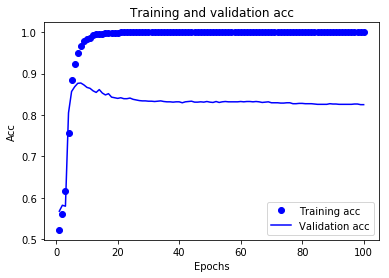

In [64]:
plot_acc(history1)